# Calculo de AUC

In [7]:
# ===================== TODO EN UNA CELDA (FINAL DEFINITIVO) =====================

import os
import torch
import hydra
from hydra import compose, initialize_config_dir
from omegaconf import OmegaConf
from pytorch_lightning import LightningModule
from torchmetrics import AUROC

# -------------------------------------------------------------
# 0) PATHS ABSOLUTOS
# -------------------------------------------------------------
CONFIGS_DIR = "/media/pc/MainWork/Codes/TransLowNet_enero_2026/AnomalyClip/configs"
CKPT_PATH = "/media/pc/MainWork/Codes/TransLowNet_enero_2026/AnomalyClip/checkpoints/epoch_49_step_1250.ckpt"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

assert os.path.isdir(CONFIGS_DIR), "❌ configs dir no existe"
assert os.path.isfile(os.path.join(CONFIGS_DIR, "eval.yaml")), "❌ eval.yaml no existe"

# -------------------------------------------------------------
# 1) CARGAR eval.yaml CON HYDRA (NOTEBOOK SAFE + PATH ABSOLUTO)
# -------------------------------------------------------------
with initialize_config_dir(
    version_base="1.2",
    config_dir=CONFIGS_DIR,     # ← AQUÍ SÍ se permite absoluto
):
    cfg = compose(
        config_name="eval",
        overrides=[f"ckpt_path={CKPT_PATH}"],
    )

print("===== CONFIG RESUELTA POR HYDRA =====")
print(OmegaConf.to_yaml(cfg))

# -------------------------------------------------------------
# 2) INSTANCIAR DATAMODULE Y MODELO (LÍNEA CLAVE)
# -------------------------------------------------------------
print(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule = hydra.utils.instantiate(cfg.data)

print(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model)
model = model.to(DEVICE)

# -------------------------------------------------------------
# 3) CARGAR CHECKPOINT
# -------------------------------------------------------------
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=True)
print("✔ Checkpoint loaded")

# -------------------------------------------------------------
# 4) NET REAL EN eval()
# -------------------------------------------------------------
net = model.net
net.eval()
print("✔ net.eval()")

# -------------------------------------------------------------
# 5) NCENTROID
# -------------------------------------------------------------
ckpt_dir = os.path.dirname(CKPT_PATH)
ncentroid = torch.load(
    os.path.join(ckpt_dir, "ncentroid.pt"),
    map_location=DEVICE
).to(DEVICE)
print("✔ ncentroid loaded")

# -------------------------------------------------------------
# 6) DATALOADER TEST
# -------------------------------------------------------------
datamodule.setup(stage="test")
test_loader = datamodule.test_dataloader()
normal_id = datamodule.hparams.normal_id
print("✔ test dataloader ready")

# -------------------------------------------------------------
# 7) EVALUACIÓN REAL (PYTORCH PURO)
# -------------------------------------------------------------
all_scores, all_labels = [], []
auroc = AUROC(task="binary")

with torch.no_grad():
    for batch in test_loader:
        image_features, labels, _, segment_size, _ = batch

        image_features = image_features.to(DEVICE)
        labels = labels.squeeze(0).to(DEVICE)

        _, abnormal_scores = net(
            image_features,
            labels,
            ncentroid,
            segment_size,
            test_mode=True,
        )

        all_scores.append(abnormal_scores.cpu())
        all_labels.append(labels.cpu())

all_scores = torch.cat(all_scores)
all_labels = torch.cat(all_labels)

labels_binary = torch.where(all_labels == normal_id, 0, 1)
auc = auroc(all_scores, labels_binary)

print("\n===================================")
print(f"AUC ROC (frame-level): {auc.item():.4f}")
print("===================================")

# ===================== FIN DE LA CELDA =====================


MissingConfigException: In 'eval': Could not find 'hydra/default.yaml'

Available options in 'hydra':
	config
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///media/pc/MainWork/Codes/TransLowNet_enero_2026/AnomalyClip/configs
	provider=hydra-colorlog, path=pkg://hydra_plugins.hydra_colorlog.conf
	provider=schema, path=structured://

# Step 2 – ROC Curve Visualization and Midpoint Threshold Selection

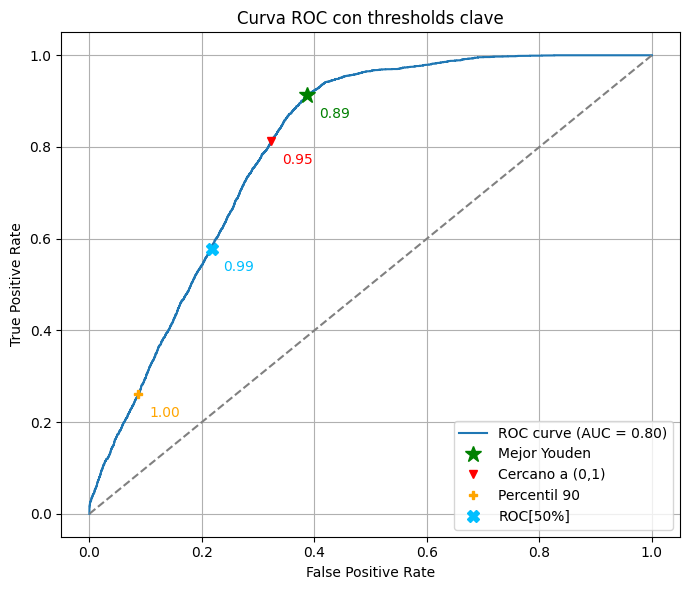


📌 Thresholds marcados en la gráfica:
🟢 Mejor Youden: 0.8908
🔴 Cercano a (0,1): 0.9510
🟠 Percentil 90: 0.9975
🔷 ROC[50%]: 0.9899


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# ROC y AUC
fpr, tpr, thresholds = roc_curve(gtLabales, scoresFull)
rec_auc = auc(fpr, tpr)
thresholds_full = np.append(thresholds, thresholds[-1])  # para alinear con fpr/tpr

# 1. Mejor Youden
youden = tpr - fpr
idx_youden = np.argmax(youden)

# 2. Cercano al punto ideal (0,1)
dist_ideal = np.sqrt((1 - tpr)**2 + fpr**2)
idx_cercano_ideal = np.argmin(dist_ideal)

# 3. Percentil 90
thr_percentil = np.percentile(scoresFull, 90)
idx_percentil = np.argmin(np.abs(thresholds - thr_percentil))

# 4. Punto medio de la curva ROC
idx_central_roc = len(fpr) // 2

# Gráfica
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {rec_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# 🟢 Mejor Youden
plt.plot(fpr[idx_youden], tpr[idx_youden], '*', color='green', markersize=12, label='Mejor Youden')
plt.text(fpr[idx_youden]+0.02, tpr[idx_youden]-0.05, f'{thresholds[idx_youden]:.2f}', color='green')

# 🔴 Cercano a (0,1)
plt.plot(fpr[idx_cercano_ideal], tpr[idx_cercano_ideal], 'v', color='red', label='Cercano a (0,1)')
plt.text(fpr[idx_cercano_ideal]+0.02, tpr[idx_cercano_ideal]-0.05, f'{thresholds[idx_cercano_ideal]:.2f}', color='red')

# 🟠 Percentil 90
plt.plot(fpr[idx_percentil], tpr[idx_percentil], 'P', color='orange', label='Percentil 90')
plt.text(fpr[idx_percentil]+0.02, tpr[idx_percentil]-0.05, f'{thresholds[idx_percentil]:.2f}', color='orange')

# 🔷 Punto medio de la curva ROC
plt.plot(fpr[idx_central_roc], tpr[idx_central_roc], 'X', color='deepskyblue', markersize=9, label='ROC[50%]')
plt.text(fpr[idx_central_roc]+0.02, tpr[idx_central_roc]-0.05, f'{thresholds_full[idx_central_roc]:.2f}', color='deepskyblue')

# Estética
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC con thresholds clave')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Consola
print("\n📌 Thresholds marcados en la gráfica:")
print(f"🟢 Mejor Youden: {thresholds[idx_youden]:.4f}")
print(f"🔴 Cercano a (0,1): {thresholds[idx_cercano_ideal]:.4f}")
print(f"🟠 Percentil 90: {thr_percentil:.4f}")
print(f"🔷 ROC[50%]: {thresholds_full[idx_central_roc]:.4f}")

# Step 3 – Final Classification Metrics (Full Test Set)

Video 0-Normal/Normal_Videos_003_x264.mp4: GT: 13, Pred: 13
Video 1-Normal/Normal_Videos_006_x264.mp4: GT: 13, Pred: 13
Video 2-Normal/Normal_Videos_010_x264.mp4: GT: 13, Pred: 13
Video 3-Normal/Normal_Videos_014_x264.mp4: GT: 13, Pred: 13
Video 4-Normal/Normal_Videos_015_x264.mp4: GT: 13, Pred: 13
Video 5-Normal/Normal_Videos_018_x264.mp4: GT: 13, Pred: 13
Video 6-Normal/Normal_Videos_019_x264.mp4: GT: 13, Pred: 4
Video 7-Normal/Normal_Videos_024_x264.mp4: GT: 13, Pred: 13
Video 8-Normal/Normal_Videos_025_x264.mp4: GT: 13, Pred: 13
Video 9-Normal/Normal_Videos_027_x264.mp4: GT: 13, Pred: 13
Video 10-Normal/Normal_Videos_033_x264.mp4: GT: 13, Pred: 13
Video 11-Normal/Normal_Videos_034_x264.mp4: GT: 13, Pred: 13
Video 12-Normal/Normal_Videos_041_x264.mp4: GT: 13, Pred: 13
Video 13-Normal/Normal_Videos_042_x264.mp4: GT: 13, Pred: 13
Video 14-Normal/Normal_Videos_048_x264.mp4: GT: 13, Pred: 13
Video 15-Normal/Normal_Videos_050_x264.mp4: GT: 13, Pred: 13
Video 16-Normal/Normal_Videos_051_x

/tmp/ipykernel_22314/1923412568.py:14: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no 

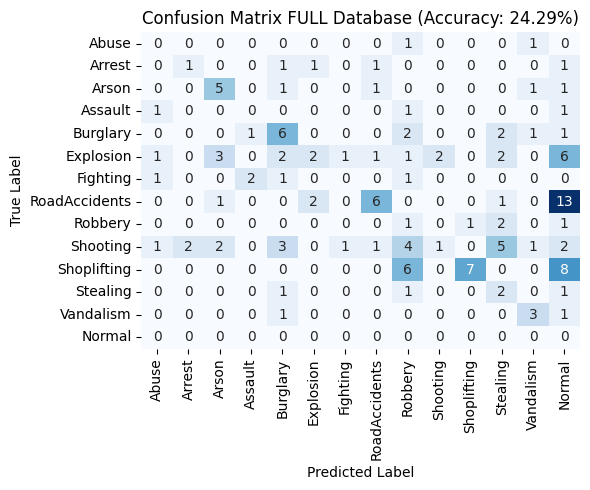

In [ ]:
import os 
import time
import numpy as np
from collections import Counter
from sklearn.metrics import (
    auc, roc_curve, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
import seaborn as sns

def confusionMat(gt, predictions):
    """Compute confusion matrix and normalized confusion matrix."""
    cm = confusion_matrix(gt, predictions)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    mean_avg_acc = np.sum(cm.diagonal()) / np.sum(cm)
    mean_avg_acc_norm = np.sum(cmn.diagonal()) / cm.shape[0]
    return cm, cmn, mean_avg_acc, mean_avg_acc_norm


def plot_confusion_matrices(cm, cmn, labels, mean_avg_acc, mean_avg_acc_norm, epoc = None, pathSave_Data = "", ModeName = "Test"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix {ModeName} (Accuracy: {mean_avg_acc*100:.2f}%)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    # plt.savefig(pathSave_Data + "/" + ModeName + ".png")
    plt.show()

fullClasses = ['Abuse',         
                  'Arrest', 
                  'Arson', 
                  'Assault', 
                  'Burglary', 
                  'Explosion', 
                  'Fighting', 
                  'RoadAccidents', 
                  'Robbery', 
                  'Shooting', 
                  'Shoplifting', 
                  'Stealing', 
                  'Vandalism',
                  'Normal']


mainPath = f"/media/pc/backup1/BaseDeDatos/UCF-Crime/Features/FrameLevel/ImageBind_Huge_UCF_Crime_Torch"
txtPath = [f"/media/pc/MainWork/Codes/MissionGNN/adap_embedding/Anomaly_Train.txt", f"/media/pc/MainWork/Codes/MissionGNN/adap_embedding/Temporal_Anomaly_Annotation.txt"]
checkpoint = f"/media/pc/MainWork/Codes/TransLowNet_enero_2026/MissionGNN/checkpoints/best_87mauc.pt"
selectSet = 1
txtPath = txtPath[selectSet]


pathVideos = np.loadtxt(txtPath, dtype=str)
testPaths = []
gtClasses = []
classChange = 0
firstAbnormal = "Abuse"
for rawData in pathVideos:
    classVAR, videoName = rawData[1], rawData[0]
    newpath = f"{classVAR}/{videoName}"
    if classVAR == "Normal":
        gtClasses.append(13)
    else:
        if firstAbnormal == classVAR:
            classChange = classChange
        else:
            firstAbnormal = classVAR
            classChange += 1
        gtClasses.append(classChange)

    testPaths.append(newpath)
pathVideos =  testPaths

fullClassDatabasePred = []

classesFull_Test = classesFull
thrTest = thr_percentil
for indVideo, nameVideo in enumerate(pathVideos):
    pathEmbeddingsPT_new = os.path.join(mainPath, f"{nameVideo[:-4]}")
    fullEmbeddings = sorted(os.listdir(pathEmbeddingsPT_new))
    lenVideo = len(fullEmbeddings)



    videoInference = classesFull_Test[indVideo]
    classFrame = []
    for probs in videoInference:
        anomaly_score = 1.0 - probs[:, 0]  
        if anomaly_score < thrTest:
            classFrame.append(13)
        else:
            pred_class = np.argmax(probs[:, 1:])
            classFrame.append(pred_class)

    justAbnormalClass = [x for x in classFrame if x != 13]
    if justAbnormalClass:
        most_common_class = Counter(justAbnormalClass).most_common(1)[0][0]
    else:
        most_common_class = 13

    fullClassDatabasePred.append(most_common_class)

    print(f"Video {indVideo}-{nameVideo}: GT: {gtClasses[indVideo]}, Pred: {most_common_class}")




# =========================
# Summary Metrics
# =========================

setVerify = 150
cm, cmn, mean_avg_acc, mean_avg_acc_norm = confusionMat(gtClasses[setVerify:], fullClassDatabasePred[setVerify:])
print("Confusion Matrix: ", mean_avg_acc, mean_avg_acc_norm)
print("Accuracy:", accuracy_score(gtClasses[setVerify:], fullClassDatabasePred[setVerify:]) * 100)
print(classification_report(gtClasses[setVerify:], fullClassDatabasePred[setVerify:], digits=4))

plot_confusion_matrices(cm, cmn, fullClasses, mean_avg_acc, mean_avg_acc_norm, 0, pathSave_Data="", ModeName="FULL Database")




# mAUC 

In [ ]:
# import numpy as np


# gtPreview = np.load("/media/pc/MainWork/Codes/TransLowNet_enero_2026/MissionGNN/GT_classes.npy")

# newList = []
# for i in range(len(gtPreview)):
#     if gtPreview[i] == 7:
#         newList.append(0)
#     elif gtPreview[i] <= 6:
#         newList.append(int(gtPreview[i] + 1))
#     else:
#         newList.append(int(gtPreview[i]))



# newList_2 = newList[244842:244842 + 648905] + newList[:244842] + newList[-218061:]
# # newList_2.append(newList[:244842])
# # newList_2.append(newList[-218079:])


# # for indexFrame in range(244842):
# #     newList_2.append(newList[indexFrame])

# # for indexFrame in range(218079):
# #     newList_2.append(newList[-218079 + indexFrame:])

# print(len(newList_2), sum(newList_2[648905:]))
# print(newList_2[648905 + 150: 648905 + 300])


# np.save("GT_classes_2.npy", newList_2)

# # classesFull_Test = classesFull
# # for index, i in enumerate(classesFull_Test):
# #     print(f"Index: {index}, Cantidad de datotos del indice {index}:{len(i)}, Estructura de un dato:{i[index][0].shape}")

1111808 564176
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import numpy as np
import os 
import torch
from torchmetrics.classification import Accuracy, MulticlassAUROC, Precision

gtClasses_2 = np.load("/media/pc/MainWork/Codes/TransLowNet_enero_2026/MissionGNN/GT_classes_2.npy")
classesFull_Test = classesFull
all_frames = []
for video in classesFull_Test:
    for frame in video:
        all_frames.append(frame)
all_frames = np.array(all_frames)
all_frames = all_frames.squeeze(1)

all_frames = torch.from_numpy(all_frames).float()
gtClasses_2 = torch.from_numpy(gtClasses_2).long()

mc_auroc = MulticlassAUROC(
            num_classes= 14, average=None, thresholds=None
        )

mc_auroc = mc_auroc(all_frames, gtClasses_2)

mc_auroc_without_normal = mc_auroc[1:]
mc_auroc_without_normal[mc_auroc_without_normal == 0] = torch.nan
mean_mc_auroc = torch.nanmean(mc_auroc_without_normal)

print(mean_mc_auroc, len(mc_auroc))



tensor(0.8612) 14


# Time inference

In [1]:
import torch
import torch.nn as nn
from imagebind.models.imagebind_model import ModalityType
import imagebind
from ptflops import get_model_complexity_info
from thop import profile, clever_format
from models.missiongnn import MissionGNN
from imagebind import data
import time
from tqdm import tqdm
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_imageBin = imagebind.models.imagebind_model.imagebind_huge(pretrained=True)
model_imageBin.eval().to(device)

checkpoint = f"/media/pc/MainWork/Codes/TransLowNet_enero_2026/MissionGNN/checkpoints/best_87mauc.pt"
model_MissionGNN = MissionGNN().to(device)
model_MissionGNN.load_state_dict(torch.load(checkpoint, map_location=device))
model_MissionGNN.eval()

seq_len = 1
mask = torch.zeros(30)
mask[-seq_len:] = 1
mask = mask.unsqueeze(0)

image_paths = []
for i in range(30):
    image_paths.append("/media/pc/backup1/BaseDeDatos/UCF-Crime/DatabaseFrames/Abuse/Abuse001_x264/imag0000000.jpg")

rewindSize = 100
torch.cuda.synchronize()
start = time.time()
for item in tqdm(range(rewindSize), desc="Procesando ítems"):
    # start = time.time()

    inputs = {ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device)}
    with torch.no_grad():
        embeddings = model_imageBin(inputs)

    clipAnalysed = []
    for j in range(30):
        clipAnalysed.append(embeddings[ModalityType.VISION][j])

    sensors = torch.stack(clipAnalysed).unsqueeze(0)
    with torch.no_grad():
        probs = torch.softmax(model_MissionGNN(sensors.to(device), mask.to(device)), dim=-1)

    anomaly_score = 1.0 - probs[:, 0] 
    pred_class = np.argmax(probs[:, 1:].cpu().numpy())

torch.cuda.synchronize()
elapsed_time = time.time() - start

fps = rewindSize*30 / elapsed_time

print(f"FPS promedio: {fps:.2f}")



/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pc/miniconda3/envs/misso_1/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: Future

FPS promedio: 28.16


In [4]:
pred_class = np.argmax(probs[:, 1:].cpu().numpy())
